[View in Colaboratory](https://colab.research.google.com/github/orico/PCAvsAutoencoder/blob/master/PCA_vs_Autoencoder_tutorial.ipynb)

A lot have been written about using a linearly activated autoencoder (AE) to approximate principal component analysis (PCA). From a math point of view, minimizing the reconstruction error in PCA is the same as AE [1]. However, why limit ourselves to linear transformations? Neural nets are very flexible, therefore we can introduce nonlinearities by using nonlinear activation functions [2]. Our Hypothesis is that the subspace spanned by the AE will be similar to the one found by PCA [3]. Additionaly, a technical disadvantage of using PCA is the requirement to run it again whenever new data is introduces, a 'feature' lacking in neural nets.

In this study we'll see the similarities and differences between PCA, a linear and non linear autoencoders. 
Note: Please read [4] if you dont have a background with AE.

[1] [CSC 411: Lecture 14: Principal Components Analysis &
Autoencoders](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf), page 16.

[2] [A Tutorial on Autoencoders for Deep Learning](https://lazyprogrammer.me/a-tutorial-on-autoencoders/)

[3] [what are the differences between pca and autoencoder](https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder) 

[4] [building AE in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

Using TensorFlow backend.


First, lets load up the Iris data-set and scale it between [0,1].

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Then we use the data-set to fit a PCA and plot the first two PCs against each other, clearly two clusters emerge.

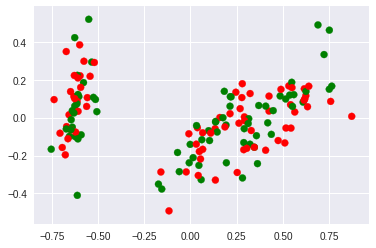

In [3]:
pca = decomposition.PCA()
pca_transformed = pca.fit_transform(X_scaled)
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],color=['red','green'])
plt.show() 

Our first network is a linear AE that has 3 layers (encoding, hidden and decoding), the encoding and decoding layers have 'linear activations' and the hidden layer has 3 layers. We selected 3 neyrons for the hidden layers because  Essentially this structure approximates PCA with linear transformation. As you can see the model converges quite nicely and our validation loss 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


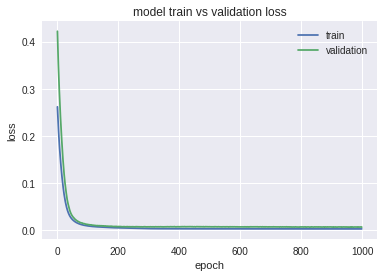

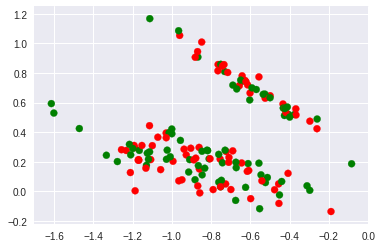

In [5]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plt.scatter(encoded_data[:,0],encoded_data[:,1],color=['red','green'])
plt.show() 


Our second AE is of similar structure, but the activation functions is a sigmoid. This network structure can be thought of PCA with nonlinear transformation.

Non linear AE using sigmoid.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


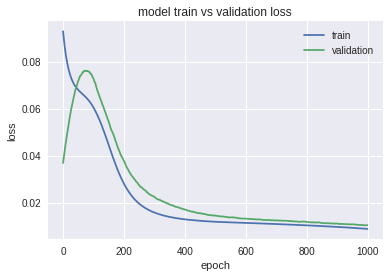

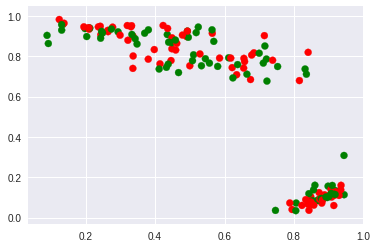

In [6]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2  
input_img2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_img2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')
print(autoencoder2.summary())

history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=2000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_img2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plt.scatter(encoded_data2[:,0],encoded_data2[:,1],color=['red','green'])
plt.show()

Our third AE is of similar structure to the second, but the activation functions is a relu with an L2 regularizer. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


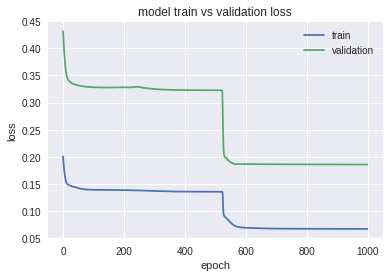

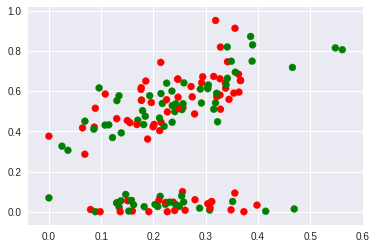

In [12]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2  
input_img3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l2(10e-5))(input_img3)
decoded3 = Dense(input_dim3, activation='relu')(encoded3)
autoencoder3 = Model(input_img3, decoded3)
autoencoder3.compile(optimizer='adam', loss='mse')
print(autoencoder3.summary())

history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder3 = Model(input_img3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plt.scatter(encoded_data3[:,0],encoded_data3[:,1],color=['red','green'])
plt.show() 


After training the AE's and pushing our training data through the hidden layer, we compare the raw data of the first 3 PCs and the AE's dense features. As we expected, for this data-set, plotting two vectors against each other will result in similar clusters in different configuration. Additionally, printing out the raw data shows a different range of values. Next we would like to compare how a simple KMEANS with 2 clusters labels the data.

In [16]:
print('PCA\n',pca_transformed[:,0:2][0:10])
print()
print('Linear AE\n',encoded_data[0:10])
print()
print('Nonlinear AE with sigmoid\n',encoded_data2[0:10])
print()
print('Nonlinear AE with relu\n',encoded_data3[0:10])


PCA
 [[-0.63036125  0.11155626]
 [-0.62354631 -0.1003132 ]
 [-0.6697928  -0.04722006]
 [-0.65463305 -0.09879127]
 [-0.64826327  0.13755769]
 [-0.534057    0.29322304]
 [-0.65639589  0.01492194]
 [-0.62564396  0.06107532]
 [-0.67652584 -0.19648232]
 [-0.64613717 -0.06324223]]

Linear AE
 [[-0.62788975  0.7500178 ]
 [-0.4053869   0.52008855]
 [-0.43376258  0.5905049 ]
 [-0.375356    0.5195364 ]
 [-0.64187104  0.7806278 ]
 [-0.8672814   0.9073841 ]
 [-0.49916616  0.6463293 ]
 [-0.5698963   0.6882458 ]
 [-0.26060858  0.42358178]
 [-0.4246997   0.5596666 ]]

Nonlinear AE with sigmoid
 [[0.877193   0.08107407]
 [0.9088016  0.14371262]
 [0.9154188  0.11005004]
 [0.91935724 0.13413666]
 [0.88012993 0.07199891]
 [0.806308   0.07251133]
 [0.9083428  0.10204269]
 [0.8854994  0.09527696]
 [0.9355361  0.16030683]
 [0.907239   0.12033226]]

Nonlinear AE with relu
 [[0.24921672 0.02728421]
 [0.13765919 0.05442891]
 [0.15977497 0.00329557]
 [0.13433671 0.02301572]
 [0.2606576  0.0068934 ]
 [0.35149354

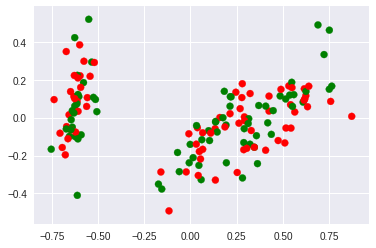

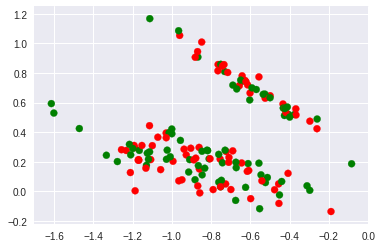

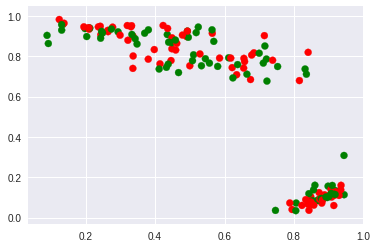

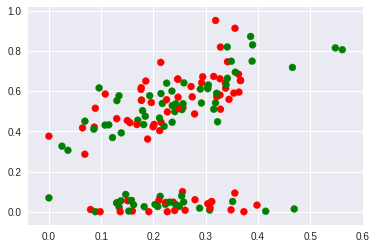

In [17]:
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data[:,0],encoded_data[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data2[:,0],encoded_data2[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data3[:,0],encoded_data3[:,1],color=['red','green'])
plt.show() 

We would like to know if each dense representation passed through a KMEANS algorithm with 2 classes can label the data similarly. The output in this section clearly shows that the classification achieved by using the output of these 4 algorithms is identical. However, please keep in mind that minor differences can happen due to the random nature of neural networks.

In [18]:
estimators = [('PCA'    , KMeans(n_clusters=2), pca_transformed),
              ('AE linear' , KMeans(n_clusters=2), encoded_data),
              ('AE sigmoid' , KMeans(n_clusters=2), encoded_data2),
              ('AE relu', KMeans(n_clusters=2), encoded_data3)]
fignum = 1
titles = ['PCA', 'Linear AE', 'Sigmoid AE', 'Relu AE']
for name, est, data in estimators:
    X = data
    est.fit(X)
    labels = est.labels_
    print(name,':')
    print(labels[:])

PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE linear :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE sigmoid :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE relu :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 